In [0]:
import numpy as np
import pandas as pd

from __future__ import unicode_literals, print_function, division
from io import open
import unicodedata
import string
import re
import random

import torch
import torch.nn as nn 
from torch import optim
import torch.nn.functional as F

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Load the Dataset 

In [2]:
dataset = pd.read_csv('/content/Hindi_English_Dataset.csv', encoding='utf-8')
dataset.head()

,source,english_sentence,hindi_sentence
0,ted,politicians do not have permission to do what ...,"राजनीतिज्ञों के पास जो कार्य करना चाहिए, वह कर..."
1,ted,"I'd like to tell you about one such child,",मई आपको ऐसे ही एक बच्चे के बारे में बताना चाहू...
2,indic2012,This percentage is even greater than the perce...,यह प्रतिशत भारत में हिन्दुओं प्रतिशत से अधिक है।
3,ted,what we really mean is that they're bad at not...,हम ये नहीं कहना चाहते कि वो ध्यान नहीं दे पाते
4,indic2012,.The ending portion of these Vedas is called U...,इन्हीं वेदों का अंतिम भाग उपनिषद कहलाता है।


## Sources of Data

In [3]:
dataset['source'].unique()

array(['ted', 'indic2012', 'tides'], dtype=object)

## Length of Dataset

In [4]:
print(dataset.shape[0])
# Randomly select 40000 sentences to train on 

dataset = dataset.sample(n=40000, random_state=42)
dataset = dataset.sample(frac=1)

127607


## Preprocessing steps
### 1) Remove NaN rows
### 2) Lower Case
### 3) Remove punctuation
### 4) Add start and end tags for target sequences
### 5) One hot encoding for both the target and train sequences


#### Remove NaN Rows

In [0]:
dataset = dataset.dropna(axis=0)

#### Lower case


In [0]:
dataset['english_sentence'] = dataset['english_sentence'].apply(lambda x: x.lower())
dataset['hindi_sentence'] = dataset['hindi_sentence'].apply(lambda x: x.lower())

#### Remove Punctuation

In [0]:
table = str.maketrans('', '', string.punctuation)

def remove_punctuation(sentence):
  stripped = [w.translate(table) for w in sentence.split()]
  sentence = ' '.join(stripped) 
  return(sentence)


dataset['english_sentence'] = dataset['english_sentence'].apply(lambda x: remove_punctuation(x))
dataset['hindi_sentence'] = dataset['hindi_sentence'].apply(lambda x: remove_punctuation(x))

#### Add start and end tags

In [0]:
dataset['hindi_sentence'] = dataset['hindi_sentence'].apply(lambda x: '<start> ' + x + ' <end>')
dataset['english_sentence'] = dataset['english_sentence'].apply(lambda x: x + ' <end>')

#### Find maximum length of a sentence

In [0]:
dataset['length_english'] = dataset['english_sentence'].apply(lambda x: len(x.split()))
dataset['length_hindi'] = dataset['hindi_sentence'].apply(lambda x: len(x.split()))

In [10]:
dataset = dataset.loc[dataset['length_english'] < 20]
dataset = dataset.loc[dataset['length_hindi'] < 20]
print(dataset.shape[0])

25280


#### One hot encoding

In [0]:
from collections import Counter
def create_lookup_tables(text):
    """
    Create lookup tables for vocabulary.

    params: 
      text: The text of tv scripts split into words

    returns: 
      A tuple of dicts (vocab_to_int, int_to_vocab)
    """
    words_frequency = Counter(text)
    sorted_frequency = sorted(words_frequency, key=words_frequency.get, reverse=True)
    int_to_vocab = {ii+1: ch for ii, ch in enumerate(sorted_frequency)}
    vocab_to_int = {ch: ii for ii, ch in int_to_vocab.items()}
    # return tuple
    return (vocab_to_int, int_to_vocab)

In [0]:
all_english_words = []
all_hindi_words = []
for i in range(dataset.shape[0]):
  all_english_words.extend(dataset['english_sentence'].iloc[i].split())
  all_hindi_words.extend(dataset['hindi_sentence'].iloc[i].split())

english_vocab_to_int, english_int_to_vocab = create_lookup_tables(all_english_words)
hindi_vocab_to_int, hindi_int_to_vocab = create_lookup_tables(all_hindi_words)

#### Prepare the dataset

In [0]:
english_int_text = []
hindi_int_text = []
for i in range(dataset.shape[0]):
  english_int_text.append([english_vocab_to_int[word] for word in dataset['english_sentence'].iloc[i].split()])
  hindi_int_text.append([hindi_vocab_to_int[word] for word in dataset['hindi_sentence'].iloc[i].split()])

#### Append zeros to make each row in the data equal length for training

In [0]:
def max_sequence(sentence_list):
  return(max(len(x) for x in sentence_list))

def padded_sequence(sentence_list):
  max_length = max_sequence(sentence_list)
  for i in range(len(sentence_list)):
    sentence_list[i].extend([0] * (max_length - len(sentence_list[i])))
  return(np.array(sentence_list)) 

In [0]:
english_int_text = padded_sequence(english_int_text)
hindi_int_text = padded_sequence(hindi_int_text)

#### Train-Test Split


In [0]:
train_length = int(0.8 * english_int_text.shape[0])
# English train and test sets
english_train_text = english_int_text[:train_length]
english_test_text = english_int_text[train_length:]
# Hindi train and test sets
hindi_train_text = hindi_int_text[:train_length]
hindi_test_text = hindi_int_text[train_length:]

#### DataLoader Function

In [0]:
from torch.utils.data import TensorDataset, DataLoader

def batch_data(train_english, test_hindi, batch_size):
  """
    Batch the neural network data using DataLoader.

    Params: 
      words: The word ids of the TV scripts
      sequence_length: The sequence length of each batch
      batch_size: The size of each batch; the number of sequences in a batch

    Returns: 
      DataLoader with batched data
  """
  train_data = TensorDataset(torch.from_numpy(train_english), torch.from_numpy(test_hindi))
  loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
  return(loader)

In [18]:
dataloader = batch_data(english_train_text, hindi_train_text, 64)
# Test the dataloader
for item in iter(dataloader):
  train, test = item
  print("Training Size is: " + str(train.shape))
  print("Testing Size is: " + str(test.shape))
  break

Training Size is: torch.Size([64, 19])
Testing Size is: torch.Size([64, 19])


#### Encoder Module

In [0]:
class EncoderGRU(nn.Module):
  def __init__(self, vocab_size, embedded_size, encoding_size, max_len=19):
    super(EncoderGRU, self).__init__()
    self.vocab_size = vocab_size
    self.embedding_size = embedded_size
    self.encoding_size = encoding_size
    self.seq_len = max_len
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
    self.gru = nn.GRU(input_size=self.embedding_size, hidden_size=self.encoding_size,
                      bidirectional=True, num_layers=2)

  def forward(self, input, hidden):
    embedded = self.embedding(input).permute(1, 0, 2)
    output = embedded
    output, hidden = self.gru(output, hidden)
    return output, hidden

  def initHidden(self, batch_size):
    return torch.zeros(2*2, batch_size, self.encoding_size, device=device)


#### Test Encoder

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
encoder = EncoderGRU(len(english_int_to_vocab), 256, 256, 20)

encoder.to(device)
# obtain one sample from the data iterator
english, hindi = next(iter(dataloader))

hidden = encoder.initHidden(64)
enc_output, enc_hidden = encoder(english.to(device), hidden)

print(enc_output.size()) # max_length, batch_size, enc_units

torch.Size([19, 64, 512])


#### Decoder module

In [0]:
class BahdannauAttention(nn.Module):
  def __init__(self, hindi_vocab_size, embedding_size, attention_hidden_size, decoding_size,\
               encoding_size, seq_len=19):
    super(BahdannauAttention, self).__init__()
    self.embedding_size = embedding_size
    self.vocab_size = hindi_vocab_size
    self.decoding_size = decoding_size
    self.encoding_size = encoding_size
    self.hidden_size = attention_hidden_size
    self.seq_len = seq_len
    # inputs to output
    self.embedding = nn.Embedding(self.vocab_size, self.embedding_size)
    self.gru = nn.GRU(input_size=self.embedding_size + self.encoding_size, 
                      hidden_size=self.decoding_size, num_layers=2)
    self.fc = nn.Linear(self.decoding_size, self.vocab_size)
    # attention network
    self.attention_input_encoder = nn.Linear(self.encoding_size, self.hidden_size)
    self.attention_prev_state = nn.Linear(self.decoding_size, self.hidden_size)
    self.v = nn.Linear(self.hidden_size, 1)


  def forward(self, input, hidden, prev_encode):
    prev_encode = prev_encode.permute(1, 0, 2)
    hidden_permute = hidden.permute(1, 0, 2)
    score = torch.tanh(self.attention_input_encoder(prev_encode) + \
                       torch.mean(self.attention_prev_state(hidden_permute), dim=1).unsqueeze(1))
    attention_weights = F.softmax(self.v(score), dim=1)
    context_vector = attention_weights * prev_encode
    context_vector = torch.sum(context_vector, dim=1)
    # compute embeddings of input
    embeddings = self.embedding(input)
    # concatanate embeddings and context vector
    x = torch.cat((context_vector.unsqueeze(1), embeddings), -1).permute(1, 0, 2)
    output, hidden = self.gru(x, hidden)
    output = output.view(-1, self.decoding_size)
    final_output = self.fc(output)
    return final_output, hidden, attention_weights

  def initHidden(self, batch_size):
    return torch.zeros(2, batch_size, self.decoding_size, device=device)

#### Test Decoder

In [22]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
decoder = BahdannauAttention(len(hindi_int_to_vocab), 256, 256, 512, 256 * 2, 19)

decoder.to(device)
# obtain one sample from the data iterator
english, hindi = next(iter(dataloader))

hidden = decoder.initHidden(64)
decoder_output, decoder_hidden, _ = decoder(hindi[:,0].unsqueeze(1).to(device), hidden, enc_output)

print(decoder_output.size()) # max_length, batch_size, enc_units
print(decoder_hidden.size())

torch.Size([64, 24167])
torch.Size([2, 64, 512])


#### Train Loop

In [0]:
# Device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## TODO: Combine the encoder and decoder into one class
encoder = EncoderGRU(len(english_int_to_vocab) + 1, 256, 256, 19)
decoder = BahdannauAttention(len(hindi_int_to_vocab) + 1, 256, 256, 256*2, 256*2, 19)


encoder.to(device)
decoder.to(device)

optimizer = optim.Adam(list(encoder.parameters()) + list(decoder.parameters()), 
                       lr=0.0005)

In [24]:
criterion = nn.CrossEntropyLoss(size_average=True, ignore_index=0)

/usr/local/lib/python3.6/dist-packages/torch/nn/_reduction.py:43: UserWarning: size_average and reduce args will be deprecated, please use reduction='mean' instead.
  warnings.warn(warning.format(ret))


In [25]:
import random
EPOCHS = 40
teacher_forcing = 1
import time

for epoch in range(EPOCHS):
    start = time.time()
    
    encoder.train()
    decoder.train()
    teacher_forcing = teacher_forcing * 0.99
    total_loss = 0

    for batch, (english, hindi) in enumerate(dataloader):
        loss = 0
        if(english.size(0) != 64):
          continue
        else:
          hidden = encoder.initHidden(english.size(0))

          enc_output, enc_hidden = encoder(english.to(device), hidden.to(device))

          dec_hidden = enc_hidden.view(2, english.size(0), -1)
          dec_input = torch.tensor([[hindi_vocab_to_int['<start>']]] * english.size(0))
          use_teacher_forcing = True if random.random() < teacher_forcing else False
          if(use_teacher_forcing):
            # use teacher forcing - feeding the target as the next input (via dec_input)
            for t in range(1, hindi.size(1)):
                predictions, dec_hidden, _ = decoder(dec_input.to(device), 
                                            dec_hidden.to(device), enc_output.to(device))
                loss += criterion(predictions.to(device), hindi[:, t].to(device))
                #loss += loss_
                dec_input = hindi[:, t].unsqueeze(1)
          else:
            for t in range(1, hindi.size(1)):
                predictions, dec_hidden, _ = decoder(dec_input.to(device), 
                                            dec_hidden.to(device), 
                                            enc_output.to(device))
                loss += criterion(predictions.to(device), hindi[:, t].to(device))
                topv, topi = predictions.topk(1)
                dec_input = topi.detach()
              
          
          batch_loss = loss
          total_loss += batch_loss
          
          optimizer.zero_grad()
          
          loss.backward()

          ### UPDATE MODEL PARAMETERS
          optimizer.step()
          
          if batch % 100 == 0:
              print('Epoch {} Batch {} Loss {:.4f}'.format(epoch + 1,
                                                          batch,
                                                          batch_loss.detach().item()))
          
        
    ### Save checkpoint for model
    if epoch % 10 == 0 :
      torch.save(encoder.state_dict(), '/content/encoder_3.pth')
      torch.save(decoder.state_dict(), '/content/decoder_3.pth')

    N_BATCH = english_train_text.shape[0] // 64
    print('Epoch {} Loss {:.4f}'.format(epoch + 1, total_loss / N_BATCH))
    print('Time taken for 1 epoch {} sec\n'.format(time.time() - start))

Epoch 1 Batch 0 Loss 181.5998
Epoch 1 Batch 100 Loss 114.0977
Epoch 1 Batch 200 Loss 104.1697
Epoch 1 Batch 300 Loss 99.1777
Epoch 1 Loss 110.6428
Time taken for 1 epoch 24.933582067489624 sec

Epoch 2 Batch 0 Loss 99.7507
Epoch 2 Batch 100 Loss 102.4824
Epoch 2 Batch 200 Loss 97.2365
Epoch 2 Batch 300 Loss 93.1837
Epoch 2 Loss 97.5611
Time taken for 1 epoch 24.828964948654175 sec

Epoch 3 Batch 0 Loss 93.2880
Epoch 3 Batch 100 Loss 89.3266
Epoch 3 Batch 200 Loss 80.7259
Epoch 3 Batch 300 Loss 92.3335
Epoch 3 Loss 89.5865
Time taken for 1 epoch 24.787257194519043 sec

Epoch 4 Batch 0 Loss 82.5304
Epoch 4 Batch 100 Loss 73.9707
Epoch 4 Batch 200 Loss 80.8019
Epoch 4 Batch 300 Loss 80.9817
Epoch 4 Loss 82.2927
Time taken for 1 epoch 24.858264207839966 sec

Epoch 5 Batch 0 Loss 74.0057
Epoch 5 Batch 100 Loss 71.0280
Epoch 5 Batch 200 Loss 72.5651
Epoch 5 Batch 300 Loss 75.2797
Epoch 5 Loss 75.3787
Time taken for 1 epoch 24.86519193649292 sec

Epoch 6 Batch 0 Loss 61.6106
Epoch 6 Batch 100

In [0]:
torch.save(encoder.state_dict(), '/content/encoder_3.pth')
torch.save(decoder.state_dict(), '/content/decoder_3.pth')

In [0]:
def greedy_inference(text, encoder, decoder):
  """ Computes the greedy search output for the network.

    Parameters:
      text(string): input to run inference on
      encoder(nn.Module): trained encoder module
      decoder(nn.Module): trained decoder module

    Returns:
      decoded_words(string): inference output
      decoder_attentions(torch.tensor): attention scores for each word
  """  
  encoder.eval()
  decoder.eval()
  hidden = encoder.initHidden(1)
  input_text = [english_vocab_to_int[x.lower()] for x in text.split()]
  input_text.extend([0] * (19 - len(input_text)))
  input_text = torch.from_numpy(np.array(input_text)).unsqueeze(0)
  with torch.no_grad():
    enc_output, enc_hidden = encoder(input_text.to(device), hidden.to(device))
    dec_hidden = enc_hidden.view(2, 1, -1)
    dec_input = torch.tensor([[hindi_vocab_to_int['<start>']]])
    decoder_attentions = torch.zeros(19, 19)
    decoded_words = []
    for di in range(19):
        predictions, dec_hidden, dec_attentions = decoder(dec_input.to(device), dec_hidden.to(device), 
                                            enc_output.to(device))
        decoder_attentions[di] = dec_attentions.data.squeeze()
        topv, topi = predictions.data.topk(1)
        if topi.item() == hindi_vocab_to_int['<end>']:
          decoded_words.append('<end>')
          break
        else:
          decoded_words.append(hindi_int_to_vocab[topi.item()])
          dec_input = topi
  return(' '.join(decoded_words), decoder_attentions)
         
        

In [0]:
test1 = [(english_int_to_vocab[x]) for x in list(english_test_text[0]) if x != 0]

In [0]:
output, attentions = greedy_inference('Does this work as intended <end>', encoder, decoder)

In [114]:
output

'क्या यह काम के रूप में हैं <end>'

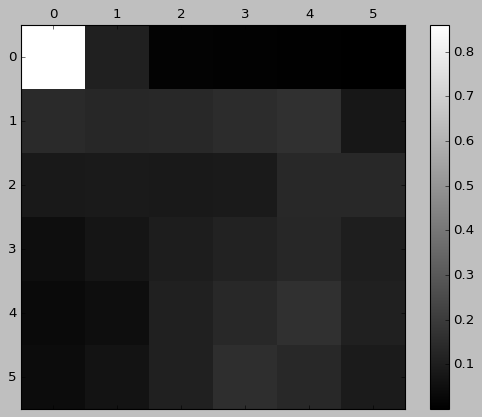

In [117]:
from matplotlib import pyplot as plt
plt.style.use('classic')
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(attentions[:6, :6].numpy(), cmap='gray')
fig.colorbar(cax)